In [1]:
!pip install pandas
!pip install transformers
!pip install torch
!pip install torchmetrics
!pip install spacy-udpipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 24.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.2/937.2 KB 55.0 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, AutoTokenizer, BertForTokenClassification
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics
from torchmetrics.classification import BinaryF1Score, BinaryPrecisionRecallCurve
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import torch
import torch.nn as nn
import transformers
import spacy_udpipe
import spacy

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_df = pd.read_csv("/content/gdrive/MyDrive/bin-prelabeled.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/test-set-bin.csv")
train_data = train_df["instance"]
test_data = test_df["instance"]
train_labels = train_df["bin_transforms"]
test_labels = test_df["bin_transforms"]

train_data = train_data.to_numpy()
train_labels = train_labels.to_numpy()
test_data = test_data.to_numpy()
test_labels = test_labels.to_numpy()
valid_data = train_data[70000:]
valid_labels = train_labels[70000:]
train_data = train_data[:70000]
train_labels = train_labels[:70000]
print(len(train_data), len(train_labels), len(test_data), len(test_labels), len(valid_data), len(valid_labels))

70000 70000 30000 30000 26265 26265


In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
training_labels = []
testing_labels = []
val_labels = []
for each in train_labels:
  training_labels.append(each.replace(" ", ""))

for each in test_labels:
  testing_labels.append(each.replace(" ", ""))

for each in valid_labels:
  val_labels.append(each.replace(" ", ""))

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)
val_labels = np.array(val_labels)

In [7]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
label_map = {'0':0, "1":1}


train_input_ids = []
test_input_ids = []
val_input_ids = []

for tokens in train_data:
    input_id = tokenizer.encode(tokens)
    train_input_ids.append(input_id)

for tokens in test_data:
    input_id = tokenizer.encode(tokens)
    test_input_ids.append(input_id)

for tokens in valid_data:
    input_id = tokenizer.encode(tokens)
    val_input_ids.append(input_id)


train_label_ids = [[label_map[label] for label in labels] for labels in training_labels]
test_label_ids = [[label_map[label] for label in labels] for labels in testing_labels]
val_label_ids = [[label_map[label] for label in labels] for labels in val_labels]

for i, (id, label) in enumerate(zip(train_input_ids, train_label_ids)):
    if len(id) > 512:
      train_input_ids[i] = id[:512]
      train_label_ids[i] = label[:512]

for i, (id, label) in enumerate(zip(test_input_ids, test_label_ids)):
    if len(id) > 512:
      test_input_ids[i] = id[:512]
      test_label_ids[i] = label[:512]

for i, (id, label) in enumerate(zip(val_input_ids, val_label_ids)):
    if len(id) > 512:
      val_input_ids[i] = id[:512]
      val_label_ids[i] = label[:512]

Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


In [9]:
#testing block
x = 0
print(train_input_ids[x])
print(len(train_input_ids[x]))
print("-----")
print(train_label_ids[x])
print(len(train_label_ids[x]))

[101, 7043, 1116, 1127, 9684, 117, 2094, 16259, 26652, 1105, 2546, 14708, 118, 1107, 2440, 170, 9853, 1590, 1113, 7602, 1150, 1108, 1103, 14708, 2050, 1211, 8362, 23630, 1193, 1825, 146, 1138, 1518, 1518, 1435, 1506, 119, 102]
38
-----
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
38


In [10]:
train_input_ids = [torch.tensor(seq) for seq in train_input_ids]
train_input_ids = nn.utils.rnn.pad_sequence(train_input_ids, batch_first=True)

train_label_ids = [torch.tensor(seq) for seq in train_label_ids]
train_label_ids = nn.utils.rnn.pad_sequence(train_label_ids, batch_first=True, padding_value = -100)

test_input_ids = [torch.tensor(seq) for seq in test_input_ids]
test_input_ids = nn.utils.rnn.pad_sequence(test_input_ids, batch_first=True)

test_label_ids = [torch.tensor(seq) for seq in test_label_ids]
test_label_ids = nn.utils.rnn.pad_sequence(test_label_ids, batch_first=True, padding_value = -100)

val_input_ids = [torch.tensor(seq) for seq in val_input_ids]
val_input_ids = nn.utils.rnn.pad_sequence(val_input_ids, batch_first=True)

val_label_ids = [torch.tensor(seq) for seq in val_label_ids]
val_label_ids = nn.utils.rnn.pad_sequence(val_label_ids, batch_first=True, padding_value = -100)


# Create attention masks for the train dataset
train_attention_masks = []
for seq, label in zip(train_input_ids, train_label_ids):
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)

# Create attention masks for the test dataset
test_attention_masks = []
for seq, label in zip(test_input_ids, test_label_ids):
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

# Create attention masks for the val dataset
val_attention_masks = []
for seq, label in zip(val_input_ids, val_label_ids):
    seq_mask = [float(i>0) for i in seq]
    val_attention_masks.append(seq_mask)

In [11]:
train_attention_masks = torch.tensor(train_attention_masks)
test_attention_masks = torch.tensor(test_attention_masks)
val_attention_masks = torch.tensor(val_attention_masks)

In [ ]:
train_label_ids[0]

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -1

In [12]:
print(train_input_ids.shape, train_label_ids.shape, test_input_ids.shape, test_label_ids.shape, val_input_ids.shape, val_label_ids.shape)

torch.Size([70000, 321]) torch.Size([70000, 321]) torch.Size([30000, 321]) torch.Size([30000, 321]) torch.Size([26265, 512]) torch.Size([26265, 512])


In [ ]:
train_input_ids = train_input_ids[:10000]
train_attention_masks = train_attention_masks[:10000]
train_label_ids = train_label_ids[:10000]
test_input_ids = test_input_ids[:4000]
test_attention_masks = test_attention_masks[:4000]
test_label_ids = test_label_ids[:4000]
val_input_ids = val_input_ids[:2000]
val_attention_masks = val_attention_masks[:2000]
val_label_ids = val_label_ids[:2000]

In [13]:
print(train_input_ids.shape, train_attention_masks.shape)

torch.Size([70000, 321]) torch.Size([70000, 321])


In [14]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_label_ids)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_label_ids)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_label_ids)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
model = transformers.BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=2)
linear = torch.nn.Linear(784, 2)
model.classification_layer = linear
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 2
temp = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
epoch_losses = []
batch_losses = []
testing_loss = []
for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, attention_masks, labels) in enumerate(train_loader):
        model.train()
        # Forward pass through the model
        inputs, labels, attention_masks = inputs.to(device), labels.to(device), attention_masks.to(device)
        optimizer.zero_grad()
        #print(inputs.shape)
        output = model(inputs, attention_mask=attention_masks, labels=labels)

        loss = output.loss
        output = output[1]
        output = output.argmax(dim=-1)
        output = output.float()
        output = output.to(device)
        
        labels = labels.float()
        
        #print(output.shape, labels.shape)   

        # Backward pass and optimization step
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += float(loss.item())
        batch_losses.append(loss.item())
        if (i + 1) % 200 == 0:
            print(f"Loss is: {loss.item()}")
    average_loss = total_loss / (i + 1)
    epoch_losses.append(average_loss)

        


    total = 0
    correct = 0
    f1_scores = []
    f1 = torchmetrics.F1Score(task='binary', num_classes=2).to(device)
    for inputs, attention_masks, labels in test_loader:
        # Forward pass through the model
        inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)
        
        model.eval()

        with torch.no_grad():
            output = model(inputs, attention_mask=attention_masks, labels = labels)
            loss = output.loss
            output = output[1]
            output = output.argmax(dim=-1)
            output = output.float()
            output = output.to(device)
            #print(output.shape, labels.shape)

            temp_labels = labels[attention_masks == 1]
            temp_output = output[attention_masks == 1]
            f1.update(temp_labels, temp_output)
        
        
            labels = labels.float()
            testing_loss.append(loss)

        total += (labels.size(0) * len(labels[0]))
        correct += (output == labels).sum()
    accuracy = 100 * correct / total
    print('Loss: {}. F1: {}'.format(average_loss, f1.compute()))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Loss is: 0.012873071245849133
Loss is: 0.029962485656142235
Loss: 0.016873200391768477. F1: 0.930747926235199
Loss is: 0.006991726811975241
Loss is: 0.000547347473911941
Loss: 0.007937361951131606. F1: 0.9225971102714539


1000


Text(0.5, 1.0, 'Average Vs Epoch')

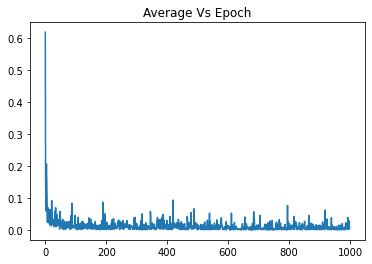

In [ ]:
#Plot:
import matplotlib.pyplot as plt
print(len(batch_losses))
epochs = range(len(batch_losses))
plt.figure()
plt.plot(epochs, batch_losses, label='Loss')
plt.title('Average Vs Epoch')

In [ ]:
#Plot:
import matplotlib.pyplot as plt
print(len(testing_loss))
epochs = range(len(testing_loss))
plt.figure()
plt.plot(epochs, testing_loss, label='Loss')
plt.title('Average Vs Epoch')

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/bin_model_v1.pt')

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = transformers.BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=2)
linear = torch.nn.Linear(784, 2)
model.classification_layer = linear
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Copy of bin_model_v1.pt', map_location=torch.device('cpu')))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:

total = 0
correct = 0
f1_scores = []
f1 = torchmetrics.F1Score(task='binary', num_classes=2).to(device)
pr_curve = BinaryPrecisionRecallCurve(thresholds=[0.]).to(device)
for i, (inputs, attention_masks, labels) in enumerate(val_loader):
        # Forward pass through the model
        #print(i)
        inputs, labels, attention_masks = inputs.to(device), labels.to(device), attention_masks.to(device)
        
        output = model(inputs, attention_mask=attention_masks)
        loss = output.loss
        output = output[0]
        output = output.argmax(dim=-1)
        output = output.float()
        output = output.to(device)
        #predictions_np = output.detach().cpu().numpy()
        #labels_np = labels.detach().cpu().numpy()
                        

        # Calculate F1 score
        temp_labels = labels[attention_masks == 1]
        temp_output = labels[attention_masks == 1]
        f1.update(temp_labels, temp_output)
        #pr_curve.update(temp_output, temp_labels)
        



        labels = labels.float()


        total += (labels.size(0) * len(labels[0]))
        correct += (output == labels).sum()
        #print(correct, total)
accuracy = 100 * correct / total
#print('Accuracy: {}'.format(accuracy))
#precisions, recalls, thresholds = pr_curve.compute()
f1_score = f1.compute()
print(f1_score)
#print(precisions)
#print(recalls)
#print(thresholds)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

tensor(1., device='cuda:0')


In [16]:
example = "I didn't ask them to make it hotter, but maybe that would solve the temp problem, sometimes asking will get you far."
def process(example):
    input_ids = tokenizer.encode(example)
    if len(input_ids) > 512:
      input_ids = input_ids[:512]
    example = [torch.tensor(seq) for seq in input_ids]
    example = [example]
    example = torch.tensor(example)
    example = example.to(device)
    output = model(example)
    output = output.logits
    output = output.argmax(dim=-1)
    output = output.float()
    output = output.tolist()[0]
    output = list(map(int, output))
    return output

print(process(example))

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [27]:
counter = 0
for i, (instance, actual) in enumerate(zip(valid_data, val_labels)):
    actual = list(actual)
    actual = list(map(int, actual))
    actual = actual[1: len(actual) - 1]
    predicted = process(instance)
    predicted = predicted[1: len(predicted) - 1]
    inst_tokens = tokenizer.tokenize(instance)
    predicted = [(tok, inst_tokens[ind]) if i != 0 else (tok) for ind, tok in enumerate(predicted)]
    actual = [(tok, inst_tokens[ind]) if i != 0 else (tok) for ind, tok in enumerate(actual)]
    if predicted != actual:
      counter += 1
      print(i, instance)
      print("Predicted", predicted)
      print("Actual   ", actual)
      print("---------")
      
  

27 Booking tip: there are always good deals at the beginning and end of the season which we managed to pick up both times.
Predicted [(0, 'Book'), (0, '##ing'), (0, 'tip'), (0, ':'), (0, 'there'), (0, 'are'), (0, 'always'), (0, 'good'), (0, 'deals'), (0, 'at'), (0, 'the'), (0, 'beginning'), (0, 'and'), (0, 'end'), (0, 'of'), (0, 'the'), (0, 'season'), (0, 'which'), (0, 'we'), (1, 'managed'), (0, 'to'), (0, 'pick'), (0, 'up'), (0, 'both'), (0, 'times'), (0, '.')]
Actual    [(0, 'Book'), (0, '##ing'), (0, 'tip'), (0, ':'), (0, 'there'), (0, 'are'), (0, 'always'), (0, 'good'), (0, 'deals'), (0, 'at'), (0, 'the'), (0, 'beginning'), (0, 'and'), (0, 'end'), (0, 'of'), (0, 'the'), (0, 'season'), (0, 'which'), (0, 'we'), (0, 'managed'), (0, 'to'), (0, 'pick'), (0, 'up'), (0, 'both'), (0, 'times'), (0, '.')]
---------
47 I wouldn't have been critical of the show in front of us, if the food was at least decent.
Predicted [(0, 'I'), (1, 'wouldn'), (0, "'"), (0, 't'), (0, 'have'), (0, 'been'), (0,

KeyboardInterrupt: ignored

In [ ]:
print(f"Sequence Level Validation Accuracy: {100 * (1 - (counter / len(valid_data)))}%")

Sequence Level Validation Accuracy: 94.9933371406815%
